In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
salesTrain = pd.read_csv('../../../data/kaggle/predicFutureSales/sales_train.csv.gz', compression= 'gzip')
items = pd.read_csv('../../../data/kaggle/predicFutureSales/items.csv')
itemCategories = pd.read_csv('../../../data/kaggle/predicFutureSales/item_categories.csv')
shops = pd.read_csv('../../../data/kaggle/predicFutureSales/shops.csv')

In [4]:
salesTrain.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
submissionData = pd.read_csv('../../../data/kaggle/predicFutureSales/sample_submission.csv.gz', compression = 'gzip')

In [7]:
submissionData.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [55]:
monthlyData = salesTrain.groupby(by = ['date_block_num','item_id'])['shop_id'].size().reset_index(name = 'item_cnt_month')
monthlyData = monthlyData.merge(salesTrain.groupby(by = ['date_block_num','item_id'])['item_price'].mean().reset_index(name = 'item_avg_price_month'), how = 'left', on = ['date_block_num', 'item_id'])
monthlyData.sort_values(by = ['item_cnt_month'], ascending = False).head()

,date_block_num,item_id,item_cnt_month,item_avg_price_month
178375,23,20949,1268,4.938533
153094,19,20949,1242,4.922032
98088,11,20949,1236,4.873346
119971,14,20949,1228,4.875210
146737,18,20949,1222,4.891861


In [205]:
# plot trends in months sales for an item
#itemData =  monthlyData.loc[monthlyData['item_id'] == 20949]
itemData =  monthlyData.loc[monthlyData['item_id'] == 33]
itemData.head()

,date_block_num,item_id,item_cnt_month,item_avg_price_month
5,0,33,58,488.517241
8121,1,33,41,484.170732
16288,2,33,31,490.870968
24590,3,33,16,489.500000
32736,4,33,11,499.000000


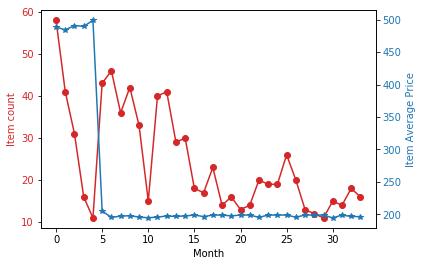

In [206]:

fig, ax = plt.subplots()
color = 'tab:red'
ax.set_xlabel('Month')
ax.set_ylabel('Item count', color = color)
ax.plot(itemData['date_block_num'].values, itemData['item_cnt_month'].values, '-o', color = color)
ax.tick_params(axis = 'y', labelcolor = color)

ax2 = ax.twinx()
color = 'tab:blue'
ax2.set_ylabel('Item Average Price', color = color)
ax2.plot(itemData['date_block_num'].values, itemData['item_avg_price_month'].values, '-*', color = color)
ax2.tick_params(axis = 'y', labelcolor = color)

plt.show()

In [207]:
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM

In [222]:
trainData = itemData.iloc[0:itemData.shape[0]-7]
testData = itemData.iloc[itemData.shape[0]-7:itemData.shape[0]]

x = itemData[['date_block_num', 'item_avg_price_month']]
itemCnt = itemData['item_cnt_month']

In [209]:
scalerGain = 1/(trainData.max() - trainData.min())
scalerOffset = trainData.min()

trainData = (trainData - scalerOffset) * scalerGain

In [223]:
def createDataset(x, itemCnt, taps=1):
    dataX, dataY = [], []
    
    for count in range(len(x)-1-taps):
        dataX.append(np.append(x.iloc[count+taps].values, itemCnt.iloc[count:count+taps]))
        dataY.append(itemCnt.iloc[count+taps])
        
    return np.array(dataX), np.array(dataY)

In [224]:
taps = 3
trainX, trainY = createDataset(trainData[['date_block_num', 'item_avg_price_month']],trainData['item_cnt_month'],taps)
testX, testY = createDataset(testData[['date_block_num', 'item_avg_price_month']],testData['item_cnt_month'],taps)

In [225]:
trainX

array([[  3.        , 489.5       ,  58.        ,  41.        ,
         31.        ],
       [  4.        , 499.        ,  41.        ,  31.        ,
         16.        ],
       [  5.        , 205.04651163,  31.        ,  16.        ,
         11.        ],
       [  6.        , 195.43913043,  16.        ,  11.        ,
         43.        ],
       [  7.        , 197.27777778,  11.        ,  43.        ,
         46.        ],
       [  8.        , 198.05238095,  43.        ,  46.        ,
         36.        ],
       [  9.        , 195.91515152,  46.        ,  36.        ,
         42.        ],
       [ 10.        , 194.86666667,  36.        ,  42.        ,
         33.        ],
       [ 11.        , 195.9       ,  42.        ,  33.        ,
         15.        ],
       [ 12.        , 197.48780488,  33.        ,  15.        ,
         40.        ],
       [ 13.        , 196.86206897,  15.        ,  40.        ,
         41.        ],
       [ 14.        , 197.67333333,  40.   

In [213]:
trainX = trainX.reshape(trainX.shape[0], 1, trainX.shape[1])
testX = testX.reshape(testX.shape[0], 1, testX.shape[1])

In [214]:
# Scale data before fitting
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))


In [226]:
scaler.fit_transform(trainData)

array([[-1.        , -1.        ,  1.        ,  0.93106472],
       [-0.92307692, -1.        ,  0.27659574,  0.9024818 ],
       [-0.84615385, -1.        , -0.14893617,  0.94654297],
       [-0.76923077, -1.        , -0.78723404,  0.9375274 ],
       [-0.69230769, -1.        , -1.        ,  1.        ],
       [-0.61538462, -1.        ,  0.36170213, -0.9330567 ],
       [-0.53846154, -1.        ,  0.4893617 , -0.99623544],
       [-0.46153846, -1.        ,  0.06382979, -0.98414438],
       [-0.38461538, -1.        ,  0.31914894, -0.97905054],
       [-0.30769231, -1.        , -0.06382979, -0.9931051 ],
       [-0.23076923, -1.        , -0.82978723, -1.        ],
       [-0.15384615, -1.        ,  0.23404255, -0.99320473],
       [-0.07692308, -1.        ,  0.27659574, -0.98276323],
       [ 0.        , -1.        , -0.23404255, -0.98687811],
       [ 0.07692308, -1.        , -0.19148936, -0.98154318],
       [ 0.15384615, -1.        , -0.70212766, -0.97281894],
       [ 0.23076923, -1.

In [216]:
model = Sequential()
model.add(LSTM(15, input_shape=(1, 5)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(trainX, trainY, epochs = 100, batch_size=1,verbose=2)

Epoch 1/100
 - 1s - loss: 0.1382
Epoch 2/100
 - 0s - loss: 0.1001
Epoch 3/100
 - 0s - loss: 0.0788
Epoch 4/100
 - 0s - loss: 0.0651
Epoch 5/100
 - 0s - loss: 0.0588
Epoch 6/100
 - 0s - loss: 0.0544
Epoch 7/100
 - 0s - loss: 0.0520
Epoch 8/100
 - 0s - loss: 0.0510
Epoch 9/100
 - 0s - loss: 0.0491
Epoch 10/100
 - 0s - loss: 0.0488
Epoch 11/100
 - 0s - loss: 0.0470
Epoch 12/100
 - 0s - loss: 0.0457
Epoch 13/100
 - 0s - loss: 0.0446
Epoch 14/100
 - 0s - loss: 0.0440
Epoch 15/100
 - 0s - loss: 0.0425
Epoch 16/100
 - 0s - loss: 0.0415
Epoch 17/100
 - 0s - loss: 0.0412
Epoch 18/100
 - 0s - loss: 0.0398
Epoch 19/100
 - 0s - loss: 0.0389
Epoch 20/100
 - 0s - loss: 0.0381
Epoch 21/100
 - 0s - loss: 0.0374
Epoch 22/100
 - 0s - loss: 0.0368
Epoch 23/100
 - 0s - loss: 0.0357
Epoch 24/100
 - 0s - loss: 0.0359
Epoch 25/100
 - 0s - loss: 0.0349
Epoch 26/100
 - 0s - loss: 0.0349
Epoch 27/100
 - 0s - loss: 0.0336
Epoch 28/100
 - 0s - loss: 0.0329
Epoch 29/100
 - 0s - loss: 0.0327
Epoch 30/100
 - 0s - lo

In [217]:
trainPredict = model.predict(trainX)
testPredcit = model.predict(testX)

In [218]:
testPredcit

array([[-2.2413769],
       [-2.2413769],
       [-2.2413769]], dtype=float32)

In [182]:
trainData - min(trainData)

TypeError: Could not operate 'date_block_num' with block values unsupported operand type(s) for -: 'float' and 'str'

array([[[   6.        ,    4.89283991,   60.        ,  684.        ,
         1149.        ]],

       [[   7.        ,    4.89286556,  684.        , 1149.        ,
         1180.        ]],

       [[   8.        ,    4.86672432, 1149.        , 1180.        ,
         1131.        ]],

       [[   9.        ,    4.87104369, 1180.        , 1131.        ,
         1088.        ]],

       [[  10.        ,    4.87974566, 1131.        , 1088.        ,
         1163.        ]],

       [[  11.        ,    4.87334625, 1088.        , 1163.        ,
         1169.        ]],

       [[  12.        ,    4.87530803, 1163.        , 1169.        ,
         1236.        ]],

       [[  13.        ,    4.8882653 , 1169.        , 1236.        ,
         1153.        ]],

       [[  14.        ,    4.87520977, 1236.        , 1153.        ,
         1031.        ]],

       [[  15.        ,    4.88672267, 1153.        , 1031.        ,
         1228.        ]],

       [[  16.        ,    4.87331448, 1

In [169]:
scaler

MinMaxScaler(copy=True,
       feature_range=(60, <bound method Series.max of 32328       60
40683      684
49152     1149
57569     1180
65627     1131
73513     1088
81419     1163
89615     1169
98088     1236
105666    1153
112825    1031
119971    1228
126743    1142
133429    1149
140112    1145
146737    1222
153094    1242
159193    1199
165423    1196
171820    1190
178375    1268
184557    1056
190607     797
196702     648
Name: item_cnt_month, dtype: int64>))